# Try CGF! Test run is on a point in time where there's an eddy parked in the beam

In [1]:
import sys
sys.path.append("/home/149/ab8992/tasman-tides/")
import xarray as xr
import ttidelib as tt
import scipy
import cmocean
import os
cmap = cmocean.cm.dense_r
import matplotlib
import matplotlib.pyplot as plt
earth_cmap = matplotlib.cm.get_cmap("gist_earth")
from datetime import timedelta
import filtering
import numpy as np
import dask
from dask.distributed import Client,default_client



def startdask():
    try:
    # Try to get the existing Dask client
        client = default_client()
        print(client)
    except ValueError:
        # If there's no existing client, create a new one
        client = Client()
        print(client)
    return client

client = startdask()


t0 = 44900 # Time in the middle of the window to be filtered
t0 = 38000
time_window = 200 # How many hours either side of t0 to consider
filter_window = 100 # How many hours either side of t0 to actually filter (subset of time window)
zl = slice(0,20)
zl = 5
expt = "notide-20"
filter_cutoff = 2*np.pi/(12.42*3600)
outpath = f"/g/data/nm03/ab8992/postprocessed/{expt}/waves"

/jobfs/111592938.gadi-pbs/ipykernel_1165996/1873024246.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  earth_cmap = matplotlib.cm.get_cmap("gist_earth")
sh: None: command not found
INFO: Compiled ParcelsRandom ==> /jobfs/111592938.gadi-pbs/parcels-16078/libparcels_random_da430044-3801-4e57-bda1-36c93251d05d.so


<Client: 'tcp://127.0.0.1:43063' processes=7 threads=28, memory=112.00 GiB>


## First read in a single that overlaps the eddy

In [2]:
def cross_scale_transfer(data):

    tau_uu = data.uu - data.u**2
    tau_uv = data.uv - data.u*data.v
    tau_vv = data.vv - data.v**2
    u = data.u
    v = data.v
    uu = data.uu
    vv = data.vv

    transfer = (
        tau_uu * u.differentiate("xb") +
        tau_uv * u.differentiate("yb") +
        tau_uv * v.differentiate("xb") +
        tau_vv * v.differentiate("yb")
    ).rename("energy_transfer")

    return transfer

def plot_transfer(data,vmax = 0.1):
    """
    data needs to contain bathy, energy transfer, b"""
    cmap = matplotlib.cm.get_cmap("RdBu")
    fig,ax = plt.subplots(2,figsize = (15,12))
    # Set the background colour to the plot to the lowest value in the cmap
    ax[0].set_facecolor("white")
    ax[1].set_facecolor("white")
    
    if type(vmax) == float or type(vmax) == int:
        data.energy_transfer.plot(ax = ax[0],cmap = cmap,add_colorbar = True,vmax = vmax,vmin = -vmax,cbar_kwargs={'label': "Energy transfer (m^2/s^3)"})
    else:
        data.energy_transfer.plot(ax = ax[0],cmap = cmap,add_colorbar = True,cbar_kwargs={'label': "Energy transfer (m/s^3)"})
    data.vorticity.plot(ax = ax[1],cmap = cmap,add_colorbar = True,cbar_kwargs={'label': "Vorticity"},vmax = 0.1,vmin = -0.1)

    data.bathy.plot(cmap = earth_cmap,vmin = -1000,vmax = 1500,ax = ax[0],add_colorbar = False)
    data.bathy.plot(cmap = earth_cmap,vmin = -1000,vmax = 1500,ax = ax[1],add_colorbar = False)

    ax[0].set_xlabel("")
    ax[0].set_title(f"Energy transfer from small to larger scales")
    ax[1].set_title(f"Vorticity")
    plt.show()
    return fig

def plot_transfer_with_phase(data,vmax = 0.1):
    """
    data needs to contain bathy, energy transfer, filtered u"""
    cmap = matplotlib.cm.get_cmap("RdBu")
    fig,ax = plt.subplots(2,figsize = (15,12))
    # Set the background colour to the plot to the lowest value in the cmap
    ax[0].set_facecolor("white")
    ax[1].set_facecolor("white")
    
    if type(vmax) == float or type(vmax) == int:
        data.energy_transfer.plot(ax = ax[0],cmap = cmap,add_colorbar = True,vmax = vmax,vmin = -vmax,cbar_kwargs={'label': "Energy transfer (m^2/s^3)"})
    else:
        data.energy_transfer.plot(ax = ax[0],cmap = cmap,add_colorbar = True,cbar_kwargs={'label': "Energy transfer (m/s^3)"})
    data.u.plot(ax = ax[1],cmap = cmap,add_colorbar = True,cbar_kwargs={'label': "velocity m/s"},vmax = 0.4,vmin = -0.4)

    data.bathy.plot(cmap = earth_cmap,vmin = -1000,vmax = 1500,ax = ax[0],add_colorbar = False)
    data.bathy.plot(cmap = earth_cmap,vmin = -1000,vmax = 1500,ax = ax[1],add_colorbar = False)

    ax[0].set_xlabel("")
    ax[0].set_title(f"Energy transfer from small to larger scales")
    ax[1].set_title(f"Filtered M2 along beam velocity")
    plt.show()
    return fig

bathy = xr.open_dataset(f"/g/data/nm03/ab8992/outputs/{expt}/bathy_transect.nc").elevation
bathy = bathy.where(bathy > 0).rename("bathy").drop_vars("lon").drop_vars("lat")

time_window = 200 # How many hours either side of t0 to consider
filter_window = 50 # How many hours either side of t0 to actually filter (subset of time window)




0.3.0


## With tide


In [16]:
t0 = 44900 # Time in the middle of the window to be filtered
expt = "full-20"
outpath = f"/g/data/nm03/ab8992/postprocessed/{expt}/lfiltered/t0-{t0}"
rawdata_tide = tt.collect_data(
    expt,
    rawdata = ["u","v"],
    timerange=(t0 - filter_window,t0 + filter_window)).isel(zl = 2,time = 100)


cst = xr.open_mfdataset(outpath + "/*.nc",decode_times = False).cst.rename("energy_transfer").persist()
vorticity = tt.calculate_vorticity(rawdata_tide).rename("vorticity")
merged = xr.merge([cst,bathy,vorticity]).load()




loading u...	

2024-03-23 17:17:56,083 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2024-03-23 17:18:08,664 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2024-03-23 17:18:23,125 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2024-03-23 17:18:40,840 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2024-03-23 17:19:00,412 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2024-03-23 17:19:22,704 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


done.
loading v...	

2024-03-23 17:20:05,771 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2024-03-23 17:20:20,683 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2024-03-23 17:20:37,874 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2024-03-23 17:20:57,507 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2024-03-23 17:21:21,589 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


done.


/jobfs/111592938.gadi-pbs/ipykernel_1162303/1966736372.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap("RdBu")


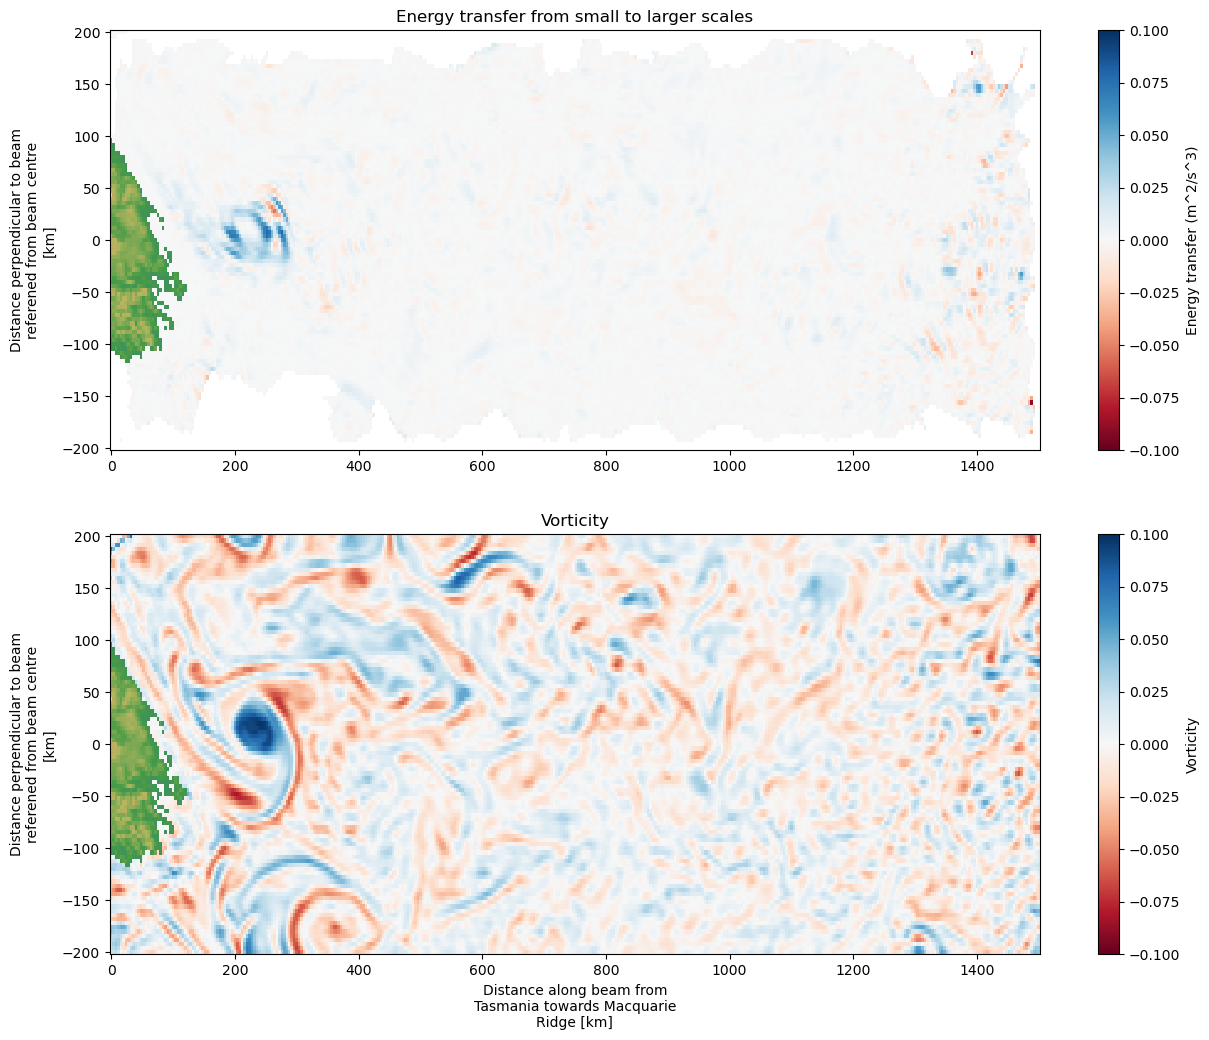

In [18]:


fig = plot_transfer(merged.integrate("zl").mean("time"))

### Make movie

In [12]:
t0 = 44900 # Time in the middle of the window to be filtered
expt = "full-20"
outpath = f"/g/data/nm03/ab8992/postprocessed/{expt}/lfiltered/t0-{t0}"
rawdata_tide = tt.collect_data(
    expt,
    rawdata = ["u","v"],
    timerange=(t0 - filter_window,t0 + filter_window)).isel(zl = 2)


cst = xr.open_mfdataset(outpath + "/*.nc",decode_times = False).cst.rename("energy_transfer").persist()
vorticity = tt.calculate_vorticity(rawdata_tide).rename("vorticity")
merged = xr.merge([cst,bathy,vorticity]).load()


tt.make_movie(merged.integrate("zl"),plot_transfer,"full-20","12hr_lagrange_cst",framerate=20,parallel = True)



loading u...	

2024-03-23 17:17:18,131 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


KeyboardInterrupt: 

## movie with M2 phase

In [26]:
t0 = 44900 # Time in the middle of the window to be filtered
expt = "full-20"
outpath = f"/g/data/nm03/ab8992/postprocessed/{expt}/lfiltered/t0-{t0}"



cst = xr.open_mfdataset(outpath + "/*.nc",decode_times = False).cst.rename("energy_transfer").persist()
u = xr.open_mfdataset(outpath + "/*.nc",decode_times = False).u.rename("u").isel(zl = 5).persist()
merged = xr.merge([cst,bathy,u]).load()

tt.make_movie(merged.integrate("zl"),plot_transfer_with_phase,"full-20","transfer_with_phase",framerate=20,parallel = True)


Making movie transfer_with_phase for full-20
/g/data/v45/ab8992/movies_tmp/tasman-tides/full-20/movies/transfer_with_phase


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 43.84 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/jobfs/111592938.gadi-pbs/ipykernel_1162303/2796160887.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
/jobfs/111592938.gadi-pbs/ipykernel_1162303/2796160887.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
/jobfs/111592938.gadi-pbs/ipykernel_1162303/2796160887.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two m

Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(1500x1200)
Figure(150

/jobfs/111592938.gadi-pbs/ipykernel_1162303/2796160887.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
/jobfs/111592938.gadi-pbs/ipykernel_1162303/2796160887.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
2024-03-23 17:39:53,519 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
/jobfs/111592938.gadi-pbs/ipykernel_1162303/2796160887.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
/jobfs/111592938.gadi-pbs/ipykern

ffmpeg -r 20  -i /g/data/v45/ab8992/movies_tmp/tasman-tides/full-20/movies/transfer_with_phase/frame_%05d.png -s 1920x1080 -c:v libx264 -pix_fmt yuv420p /g/data/v45/ab8992/dropbox/tasman-tides/full-20/moviestransfer_with_phase.mp4
ffmpeg finished with returncode 0 

 and output 


ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 11.3.0 (conda-forge gcc 11.3.0-19)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-cond

## Notide

In [21]:
t0 = 38000
expt = "notide-20"
outpath = f"/g/data/nm03/ab8992/postprocessed/{expt}/lfiltered/t0-{t0}"
# rawdata_tide = tt.collect_data(
#     expt,
#     rawdata = ["u","v"],
#     timerange=(t0 - filter_window,t0 + filter_window)).isel(zl = 2,time = 100)


cst = xr.open_mfdataset(outpath + "/*.nc",decode_times = False).cst.rename("energy_transfer").persist()
vorticity = tt.calculate_vorticity(rawdata_tide).rename("vorticity")
merged = xr.merge([cst,bathy,vorticity]).load()




/jobfs/111592938.gadi-pbs/ipykernel_1162303/1966736372.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap("RdBu")


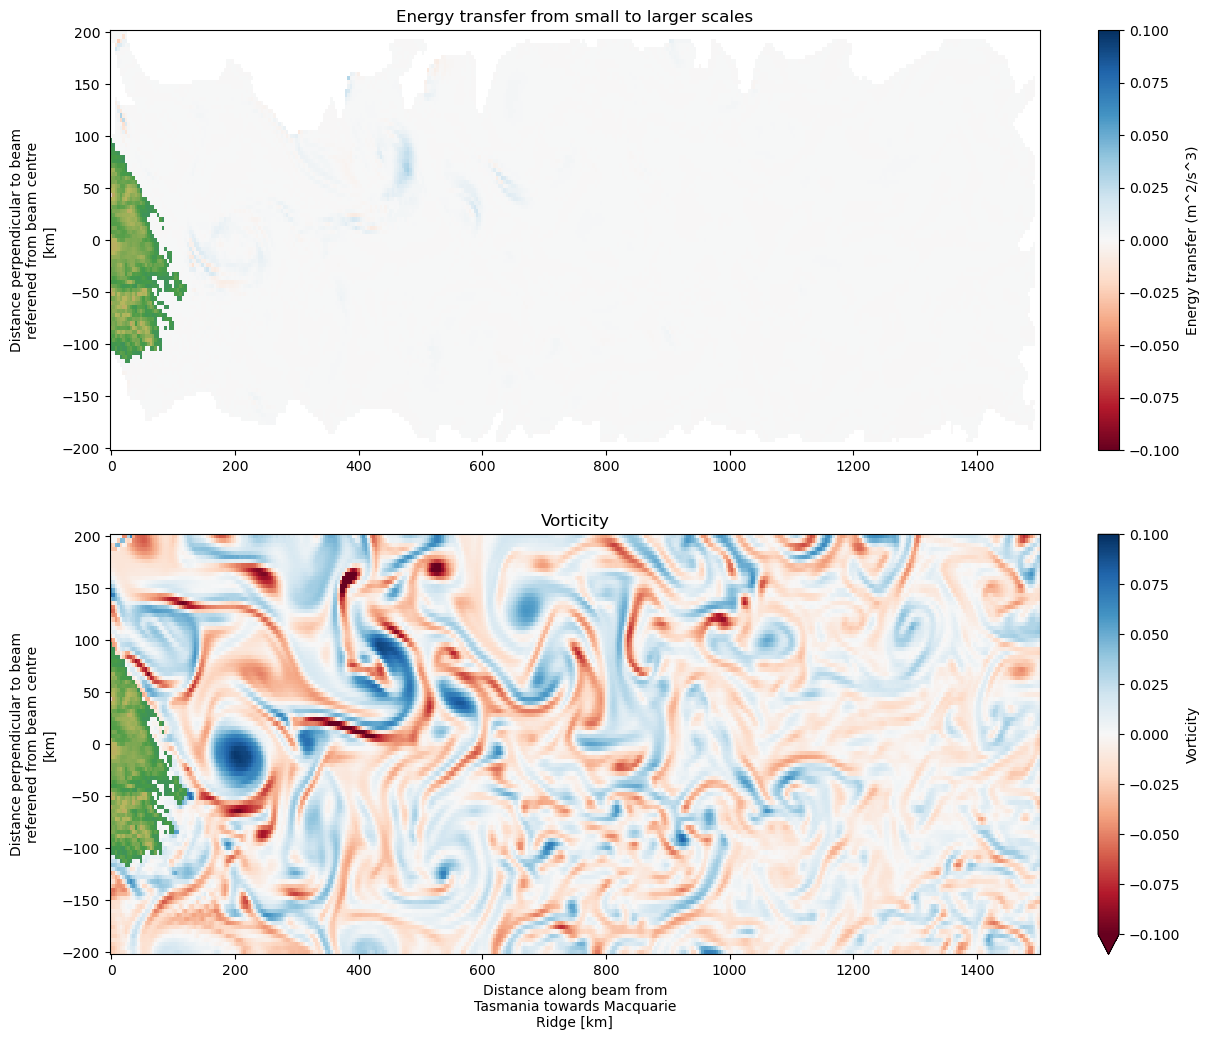

In [22]:
fig = plot_transfer(merged.mean("time").integrate("zl"),vmax = 0.1)


In [ ]:
fig = plot_transfer(merged.integrate("zl"),vmax = 1)


### Make Movie

In [ ]:
t0 = 38000
expt = "notide-20"
outpath = f"/g/data/nm03/ab8992/postprocessed/{expt}/lfiltered/t0-{t0}"
rawdata_tide = tt.collect_data(
    expt,
    rawdata = ["u","v"],
    timerange=(t0 - filter_window,t0 + filter_window)).isel(zl = 2)


cst = xr.open_mfdataset(outpath + "/*.nc",decode_times = False).cst.rename("energy_transfer").persist()
vorticity = tt.calculate_vorticity(rawdata_tide).rename("vorticity")
merged = xr.merge([cst,bathy,vorticity]).load()


tt.make_movie(merged.integrate("zl"),plot_transfer,expt,"12hr_lagrange_cst",framerate=20)

In [3]:
t0 = 38000
expt = "notide-20"
outpath = f"/g/data/nm03/ab8992/postprocessed/{expt}/lfiltered/t0-{t0}"



cst = xr.open_mfdataset(outpath + "/*.nc",decode_times = False).cst.rename("energy_transfer").persist()
u = xr.open_mfdataset(outpath + "/*.nc",decode_times = False).u.rename("u").isel(zl = 2).persist()
merged = xr.merge([cst,bathy,u]).load()

tt.make_movie(merged.integrate("zl"),plot_transfer_with_phase,"notide-20","transfer_with_phase",framerate=20,parallel = True)


Making movie transfer_with_phase for notide-20
/g/data/v45/ab8992/movies_tmp/tasman-tides/notide-20/movies/transfer_with_phase


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 43.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/jobfs/111592938.gadi-pbs/ipykernel_1165996/2796160887.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
/jobfs/111592938.gadi-pbs/ipykernel_1165996/2796160887.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
/jobfs/111592938.gadi-pbs/ipykernel_1165996/2796160887.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two m

ffmpeg -r 20  -i /g/data/v45/ab8992/movies_tmp/tasman-tides/notide-20/movies/transfer_with_phase/frame_%05d.png -s 1920x1080 -c:v libx264 -pix_fmt yuv420p /g/data/v45/ab8992/dropbox/tasman-tides/notide-20/moviestransfer_with_phase.mp4
ffmpeg finished with returncode 0 

 and output 


ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 11.3.0 (conda-forge gcc 11.3.0-19)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-

## Plot velocities

In [ ]:
np.log((filtered.u**2)).mean("time").mean("zl").plot()

## Plot outputs of Lagrangian runs